# Challenge 2 - Long-term model

In [2]:
# import packages
import pandas as pd
import numpy as np
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
plt.style.use('bmh')

# 1. Pre-modeling analysis

In [3]:
raw_url = 'https://raw.githubusercontent.com/leoiania/interviews-data-science-assignment/1b0d1c082053383f7f292f17e95f830cd259bbcc/datasets/italian-power-load/load.csv'
data = pd.read_csv(raw_url, parse_dates=['Date'], index_col='Date')

Now we have a specific task: create a model capable to predict values 1 year ahead. In pursuing this goal, remembering the behaviours of the model in the years that we've seen in the first part (report), I decided to take into account all the data from 2006 to 2018.

Then, as required, data from 2019 are used as test set.

In [4]:
# split data:
train_data = data.loc[:'2018']
test_data = data.loc['2019']

Due to this type of behaviour of the series, in my opinion we need an autoregressive model in which the values predicted at times t takes into account values of long-time before, to "intercept" the annual pattern.

To select the relevant lag that needs to be considered, we can plot again ACF and PACF but with longer lags.

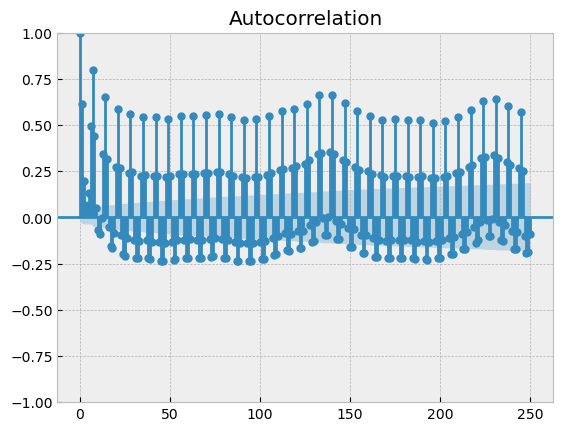

In [5]:
statsmodels.graphics.tsaplots.plot_acf(train_data['Load'],lags=250);
plt.show();

c:\ProgramData\Anaconda3\envs\text_mining\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


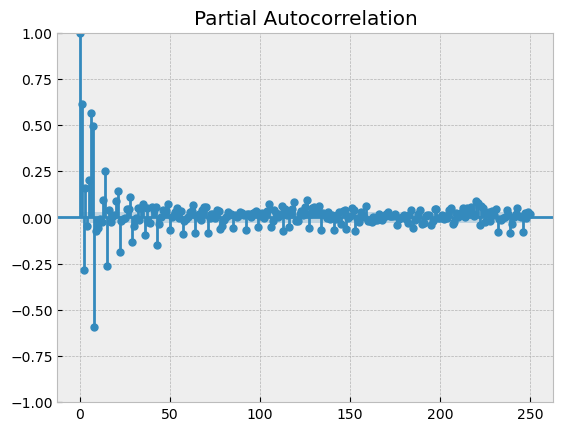

In [6]:
statsmodels.graphics.tsaplots.plot_pacf(train_data['Load'],lags = 250);
plt.show();

We observe, expecially in the autocorrelation function (1st plot), a cyclic trend that is high-related with a value close to 150 previous time. We can inspect it in details to have a more precise idea:

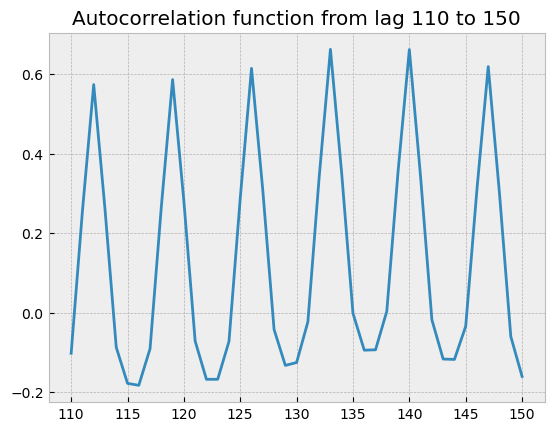

In [7]:
acfvalues= statsmodels.tsa.stattools.acf(train_data['Load'],nlags=250)
acfvalues = pd.DataFrame(acfvalues.reshape(len(acfvalues),1))

plt.plot(acfvalues.loc[110:150])
plt.title('Autocorrelation function from lag 110 to 150')
plt.show()

The value is very high for lag = 140, close to 0.7 (the maximum value that it can reach is 1).

# 2. Modeling (training)

From the analysis up to now, I can conclude that the best family of models to use are the Seasonal ARMA.

The one presented takes into account directly only the observations at t-140 for explaining the value at time t. That means, roughly speaking, that the value of today depends on the value of about 4 months and 2 weeks ago.

The value suggested by the partial autoregression was 126 (even if it is not shown before), but the model had worse performances.

Moreover, I tried to capture the observations 1/2/3 immediatly before but the model obtained worse forecast ability, and this is due to the fact that it is highly affected by the forecasted value DURING the year.

So, the model that you can see below is resulting after different tests.

In [8]:
model = sm.tsa.statespace.SARIMAX(train_data,
                                  order=(0,0,0),
                                  seasonal_order=(1,0,0,140),                                 
                                  freq='D')

# fit the model to the data
results = model.fit()

c:\ProgramData\Anaconda3\envs\text_mining\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Before looking at the "future", take a look at the summary and then we can observe how the model fits the training data 

In [9]:
print(results.summary())

                                 SARIMAX Results                                 
Dep. Variable:                      Load   No. Observations:                 4748
Model:             SARIMAX(1, 0, 0, 140)   Log Likelihood              -61429.528
Date:                   Fri, 03 Mar 2023   AIC                         122863.056
Time:                           13:16:29   BIC                         122875.987
Sample:                       01-01-2006   HQIC                        122867.600
                            - 12-31-2018                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L140      0.9941      0.001    698.717      0.000       0.991       0.997
sigma2      8.831e+09    3.4e-15    2.6e+24      0.000    8.83e+09    8.83e+09
Ljung-Box (L1) (Q):         

The coefficient is the result of a high correlation with the values at lag 140.

The other informations are not useful in forecasting, instead we can see if the model fits well the training data excluding the first part, where the values are 0 because we cannot fit the model for the first 139 days (due to the structure of the model).

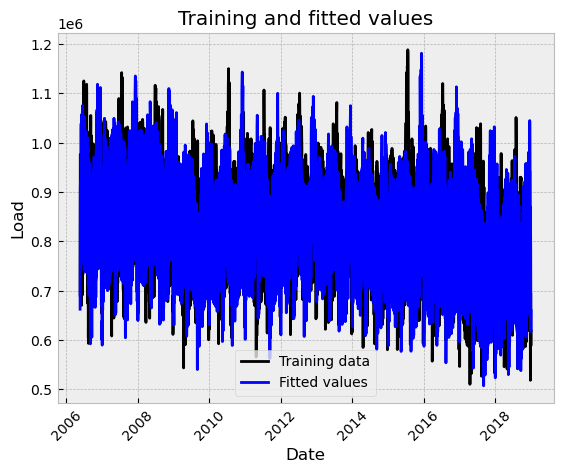

In [10]:
plt.plot(train_data[140:], color = "black",label = 'Training data')
plt.plot(results.fittedvalues[140:], color='blue', label = 'Fitted values')
plt.ylabel('Load')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Training and fitted values")
plt.legend()
plt.show()

We can expect also a good results for the residuals. We can plot it, remembering the expected problem for the first 139 values:

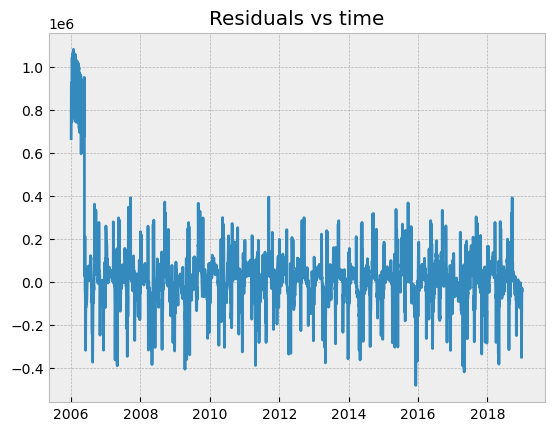

In [11]:
plt.plot(results.resid)
plt.title('Residuals vs time')
plt.show()

Very well, excluding the first values they are all equally distributed around 0.

# 3. Forecast test and evaluation

To evaluate the performance of the model in 2019, we need as first thing to obtain the forecast. 

For the first 4 months they are related to values observed in 2019, then they will be based on predicted values.

In [12]:
# obtaining forecasts
preds = results.forecast(steps=365)

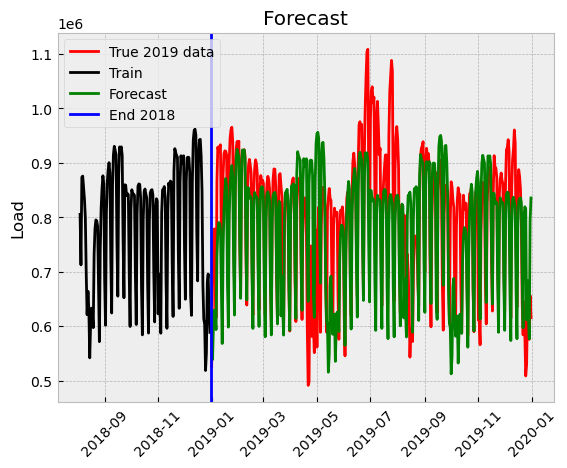

In [13]:
plt.plot(test_data, color = "red",label = 'True 2019 data')
plt.plot(train_data.loc['2018'][-150:-1], color = "black", label = 'Train')
plt.plot(preds, color='green', label = 'Forecast')
plt.axvline(pd.Timestamp('2018-12-31'),color='blue', label='End 2018')
plt.ylabel('Load')
plt.xticks(rotation=45)
plt.title("Forecast")
plt.legend()
plt.show()

Of course the model is not very able in predicting values that are further away from the ordinary (observable in april and july 2019).

To have a numerical measure of the performance, we can use the classical RMSE comparing forecast for 2019 with the original data of this year:

In [14]:
ann19_rmse = mean_squared_error(test_data.Load.values,preds,squared = False)
print('Absolute RMSE: ',ann19_rmse)

Absolute RMSE:  105688.680022649


We cannot states whether it is high or not if we look at an absolute values like this. 

We can divide it by the range of our data, interpreting it as the percentage of average error in forecast:

In [15]:
range_19 = (np.max(data.Load.values)-np.min(data.Load.values))
print('Relative RMSE (to the range of the data): ', ann19_rmse/range_19)

Relative RMSE (to the range of the data):  0.14481826329784764


This result is quite good, telling us that the error is about the 17% of how wide are the values we're dealing with.

At the end of this part, since this is the model that I want to use also for 2020 and 2021 forecast, I save it as `1_y_model`

In [16]:
# results.save('1_y_model')